#Perceptrón aplicado a Digits


### 1. Lectura


Dimensiones de X: (1797, 64)
Dimensiones de y: (1797,)
Ejemplo: La primera imagen es un 0


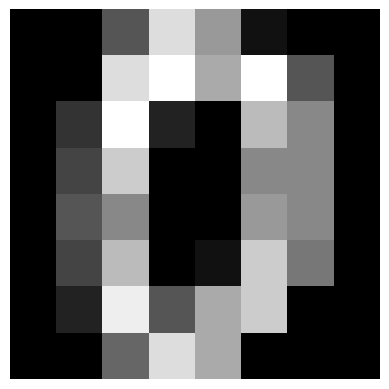

In [1]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# 1. Cargar el dataset Digits
digits = load_digits()

# 2. Asignar X (datos) e y (etiquetas)
# X son las imágenes aplanadas (64 números por imagen)
X = digits.data.astype(np.float16)
# y son los números correctos (0, 1, 2, 3...)
y = digits.target.astype(np.uint)

# 3. NORMALIZACIÓN
# Los píxeles van de 0 a 16. Dividimos por 16 para que vayan de 0 a 1.
# Si no haces esto, el Perceptrón fallará.
X = X / 16.0

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

# Comprobación visual
print(f"Ejemplo: La primera imagen es un {y[0]}")
plt.imshow(digits.images[0], cmap='gray')
plt.axis('off')
plt.show()

### 2. Partición del corpus
Dividimos los datos en entrenamiento (70%) y test (30%).
Usamos 'stratify=y' para mantener la proporción de cada número.

In [2]:
from sklearn.model_selection import train_test_split

# Usamos test_size=0.3 (30% para examen, 70% para estudiar)
# stratify=y es importante: asegura que haya la misma cantidad en ambos lados.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42
)

print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)

X_train: (1257, 64)
X_test:  (540, 64)


### 3. Implementación del algoritmo Perceptrón

Implementación del algoritmo de aprendizaje Perceptrón, partiendo de pesos nulos.

Recibe como parámetros de entrada:

- Matriz de muestras de entrenamiento `X`, de tamaño $N\times D$,
- Matriz (vector columna) de etiquetas de clase `y`, de tamaño $N\times 1$,
- Valores de los hiperparámetros del algoritmo (a optimizar de manera experimental):
    - Variable de margen `b` $\ge 0$,
    - Factor de aprendizaje `a` $> 0$,
    - Número máximo de iteraciones `K` $> 0$.

Devuelve:

- Matriz de pesos optimizados `W`, en notación homogénea, de tamaño $(1+D)\times C$,  
- Número de muestras de train incorrectamente clasificadas `E` durante la última iteración realizada,
- Número de iteraciones ejecutadas `k`.

In [3]:
def perceptron(X, y, b=0.1, a=1.0, K=200):
    N, D = X.shape;                               # N: num. muestras; D: dimensionalidad
    Y = np.unique(y);                             # Y: Conjunto etiquetas de clase
    C = Y.size;                                   # C: número de clases
    W = np.zeros((1+D, C));                       # Inicialización matriz de pesos nulos
    for k in range(1, K+1):
        E = 0                                     # E: Contador de errores de clasificación
        for n in range(N):
            xn = np.array([1, *X[n, :]]);         # xn: vector x en notación compacta
            yn = np.squeeze(np.where(Y==y[n]));   # yn: etiq. de clase correcta en {0,...,C-1}
            gn = W[:,yn] @ xn;                    # gn: valor f.discr. de la clase correcta
            err = False;
            for c in np.arange(C):
                if c != yn:
                    if W[:,c] @ xn + b >= gn:     # ¿Se clasifica mal la muestra xn?
                        W[:, c] = W[:, c] - a*xn; # Ajustamos pesos de la clase incorrecta
                        err = True;
            if err:
                W[:, yn] = W[:, yn] + a*xn;       # Ajustamos pesos de la clase correcta
                E = E + 1;
        if E == 0:                                # Algoritmo converge, finalizamos entrenamiento.
            break;
    return W, E, k

**Nota 1:** el carácter `*` delante de una secuencia actúa como [operador de desempaquetado (unpacking operator)]((https://peps.python.org/pep-0448/)).

**Nota 2:** el [operador `@`](https://peps.python.org/pep-0465/) denota multiplicación de matrices.

Conviene resaltar que **el valor `E` devuelto no nos sirve para calcular la tasa de error de train**, ya que los pesos se modifican a lo largo de la iteración. La tasa de error en train se debe calcular con unos pesos fijos (invariables) para todas las muestras, p.e. al finalizar el entrenamiento, o incluso al final de cada iteración. `E` solo nos sirve para conocer el número de actualizaciones de pesos realizadas en la última iteración del algoritmo.

### 4. Aprendizaje de un clasificador lineal con Perceptrón

Perceptrón devuelve una matriz de pesos optimizados $\mathbf{W}^*$ que minimiza el número de errores de entrenamiento (con margen `b`):

$$\mathbf{W}^*=\operatorname*{argmin}_{\mathbf{W}=(\boldsymbol{w}_1,\dotsc,\boldsymbol{w}_C)}\sum_n\;\mathbb{I}\biggl(\max_{c\neq y_n}\;(\boldsymbol{w}_c^t\boldsymbol{x}_n+b) \;>\; \boldsymbol{w}_{y_n}^t\boldsymbol{x}_n\biggr)$$

In [4]:
# Entrenamos. Subimos K a 1000 iteraciones.
W, E, k = perceptron(X_train, y_train, b=0.1, a=1.0, K=1000)

print("Número de iteraciones ejecutadas:", k)
print("Errores en la última vuelta de entrenamiento:", E)

Número de iteraciones ejecutadas: 84
Errores en la última vuelta de entrenamiento: 0


### 5. Cálculo de tasas de error

**Tasa de error en train:**

Tasa de Acierto (Accuracy): 95.74%


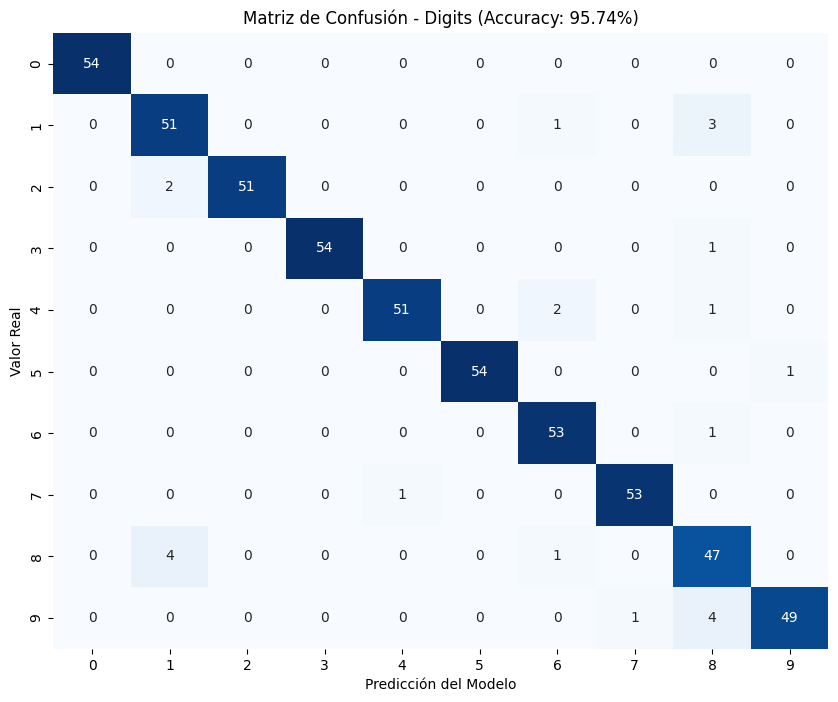

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# 1. PREDECIR
# Añadimos la columna de 1s para el sesgo (bias)
X_test_h = np.hstack([np.ones((len(X_test), 1)), X_test])
# Multiplicamos pesos por datos para obtener la predicción
y_pred = np.argmax(X_test_h @ W, axis=1)

# 2. Calcular la nota (Accuracy)
acc = accuracy_score(y_test, y_pred)
print(f"Tasa de Acierto (Accuracy): {acc:.2%}")

# 3. Dibujar la Matriz
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Matriz de Confusión - Digits (Accuracy: {acc:.2%})')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Valor Real')
plt.show()

### 6. Optimización de hiperparámetros

**Ajuste del margen:** $\;$ experimento para optimizar el valor del hiperparámetro $b$

In [ ]:
# Experimento: Probamos distintos márgenes (b) para ver cuál funciona mejor
print("{:>7s}\t{:>7s}\t{:>7s}\t{:>12s}".format("b", "Iter", "E_train", "Error_Test"))
print("-" * 50)

# Probamos b=0 (sin margen), b=0.01 (pequeño) y b=0.1 (estándar)
for b in (0.0, 0.01, 0.1):
    # 1. Entrenamos con K=1000 (necesario para Digits)
    W_b, E_b, k_b = perceptron(X_train, y_train, b=b, a=1.0, K=1000)

    # 2. Evaluamos en Test
    X_test_h = np.hstack([np.ones((len(X_test), 1)), X_test])
    y_pred_b = np.argmax(X_test_h @ W_b, axis=1)
    # Contamos errores
    errores_test = np.count_nonzero(y_pred_b != y_test)
    tasa_error = errores_test / len(X_test)

    # 3. Mostramos resultados
    print(f"{b:7.2f}\t{k_b:7d}\t{E_b:7d}\t{tasa_error:11.2%}")

      b	   Iter	E_train	  Error_Test
--------------------------------------------------
   0.00	     61	      0	      4.26%
   0.01	     72	      0	      5.19%
   0.10	     84	      0	      4.26%
